# Classification of Dogs and Cats based on https://www.kaggle.com/chetankv/dogs-cats-images/

## Part 2: Modelling with a Custom Model

In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms,models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [3]:
if torch.cuda.is_available():
    dev = "cuda:0" 
else:  
    dev = "cpu"
device = torch.device(dev) 

In [4]:
path='..\\Data\\CATS_DOGS\\'

In [5]:
train_transforms=transforms.Compose([transforms.ToTensor(), # Need to run Part 1 of the image transforms before this
                                     transforms.Normalize([0.485, 0.456, 0.406], 
                                                          [0.229, 0.224, 0.225])])
test_transforms=transforms.Compose([transforms.Resize(224), 
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])])

In [69]:
print(len(train_data))
print(len(test_data))

37486
6251


In [6]:
train_data=datasets.ImageFolder(root=path+'\\train1',transform=train_transforms)
test_data=datasets.ImageFolder(root=path+'\\test',transform=test_transforms)

torch.manual_seed(42)

train_load=DataLoader(train_data,batch_size=100,shuffle=True)
test_load=DataLoader(test_data,batch_size=10, shuffle=True)
labels=train_data.classes

In [7]:
print(labels)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

['CAT', 'DOG']
Training images available: 37486
Testing images available:  6251


In [8]:
#The only way to grab items from DataLoader is to do a single break as soon as the for loop is initialized since DataLoader items cannot be subscripted / sliced.
for data_batch,label_batch in train_load:
    print(label_batch)
    break

print('Data batch shape is:',data_batch.shape)
print('Label batch shape is:',label_batch.shape)

tensor([1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
        1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
        1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
        1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
        1, 0, 0, 0])
Data batch shape is: torch.Size([100, 3, 224, 224])
Label batch shape is: torch.Size([100])


In [9]:
print(data_batch)

tensor([[[[-1.5870, -1.6384, -1.7069,  ..., -2.1179, -2.1179, -2.1179],
          [-1.5870, -1.6384, -1.7069,  ..., -2.1179, -2.1179, -2.1179],
          [-1.6042, -1.6384, -1.6898,  ..., -2.0494, -2.0494, -2.0494],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -1.4843, -1.4843, -1.4843],
          [-2.1179, -2.1179, -2.1179,  ..., -1.4843, -1.4843, -1.4843],
          [-2.1179, -2.1179, -2.1179,  ..., -1.4843, -1.4843, -1.4843]],

         [[-1.9482, -2.0007, -2.0357,  ..., -1.9832, -1.9832, -1.9832],
          [-1.9482, -2.0007, -2.0357,  ..., -1.9832, -1.9832, -1.9832],
          [-1.9657, -2.0007, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-1.9832, -1.9832, -1.9832,  ..., -1.1779, -1.1779, -1.1779],
          [-1.9832, -1.9832, -1.9832,  ..., -1.1779, -1.1779, -1.1779],
          [-2.0357, -2.0357, -2.0357,  ..., -1.1779, -1.1779, -1.1779]],

         [[-1.7347, -1.7870, -1.8044,  ..., -1.7347, -1.7173, -1.7173],
          [-1.7347, -1.7870, -

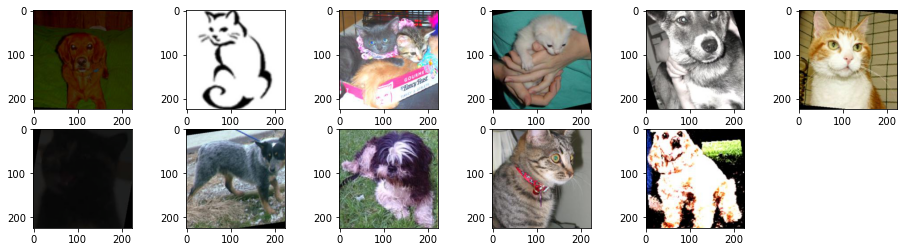

['CAT', 'DOG', 'DOG', 'CAT', 'CAT', 'CAT', 'DOG', 'CAT', 'CAT', 'DOG', 'DOG', 'CAT', 'DOG']


In [10]:
#plt.figure(figsize=(12,4))
# We have to reverse the normalization that we had applies during the transform of the images
i=1
img={}
plt.figure(figsize=(16,4))
for mat,lab in  zip(data_batch[:11],label_batch[:11]):
    #print(sample)
    invert_normalize = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                                         std=[1/0.229, 1/0.224, 1/0.225]) 
    sample_inv = invert_normalize(mat)
    sample_imshow=sample_inv.numpy().transpose(1,2,0)
    labels.append(train_data.classes[lab])
    plt.subplot(2,6,i,label=labels)
    
    plt.imshow(sample_imshow)
    i+=1
plt.show()
print(labels)


In [11]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(3,32,3,1)
        self.conv2=nn.Conv2d(32,6,3,1)
        self.conv3=nn.Conv2d(6,16,3,1)
        self.nn1=nn.Linear(16*26*26,120)
        self.nn2=nn.Linear(120,84)
        self.nn3=nn.Linear(84,10)
        self.nn4=nn.Linear(10,2)
        
    def forward(self, X):
        X=F.relu(self.conv1(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv2(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv3(X))
        X=F.max_pool2d(X,2,2)
        X=X.view(-1,16*26*26)
        X=F.relu(self.nn1(X))
        X=F.relu(self.nn2(X))
        X=F.relu(self.nn3(X))
        X=self.nn4(X)
        return F.log_softmax(X,dim=1)


In [12]:
torch.manual_seed(101)
cnn_model=CNNModel()
#cnn_model.to(torch.device("cuda:0"))
cnn_model

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (nn1): Linear(in_features=10816, out_features=120, bias=True)
  (nn2): Linear(in_features=120, out_features=84, bias=True)
  (nn3): Linear(in_features=84, out_features=10, bias=True)
  (nn4): Linear(in_features=10, out_features=2, bias=True)
)

In [13]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(cnn_model.parameters(),lr=0.001)

In [14]:
for i in cnn_model.parameters():
    print(i.numel())

864
32
1728
6
864
16
1297920
120
10080
84
840
10
20
2


In [15]:
epochs=10

In [16]:
import time

In [17]:
losses=[]
loss_train=[]
loss_test=[]

start_time=time.time()
for e in range(epochs):
    loss_epoch=[]
    acc_train=[]
    acc_test=[]
    acc_train_score=0
    acc_test_score=0
    acc_test_score=[]
    acc_train_batch=0
    acc_test_batch=0
    for batch, (train_x, train_y) in enumerate(train_load):
#         train_x
#         print(train_x.shape)
        batch+=1
        y_train_pred=cnn_model.forward(train_x)
#         print('y_train_pred.shape',y_train_pred.shape)
#         #print(y_train_pred)
#         print('y_train_pred.argmax()',y_train_pred.argmax(dim=1).shape)
#         print(train_y.shape)
        loss=criterion(y_train_pred,train_y)
        acc_train_batch+=(y_train_pred.argmax(dim=1)==train_y).sum()
        acc_train.append(acc_train_batch)
        if(batch%100==0):
            print(f' for epoch {e} and batch {batch}, training loss = {loss}, accuracy={acc_train_batch/(batch)}%')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train.append(loss)
    
    with torch.no_grad():
        for batch, (test_x, test_y) in enumerate(test_load):
    #         print(train_x.shape)
            batch+=1
            y_test_pred=cnn_model.forward(test_x)
    #         print('y_train_pred.shape',y_train_pred.shape)
    #         #print(y_train_pred)
    #         print('y_train_pred.argmax()',y_train_pred.argmax(dim=1).shape)
    #         print(train_y.shape)
            loss=criterion(y_test_pred,test_y)
            acc_test_batch+=(y_test_pred.argmax(dim=1)==test_y).sum()
            acc_test.append(acc_test_batch)
            if(batch%100==0):
                print(f' for epoch {e} and batch {batch}, test loss = loss, accuracy={acc_test_batch*10/(batch)}%')

    loss_test.append(loss)
end_time=time.time()

E:\Anaconda\envs\pytorchenv\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


 for epoch 0 and batch 100, training loss = 0.6189699172973633, accuracy=55.45000076293945%
 for epoch 0 and batch 200, training loss = 0.597620964050293, accuracy=58.20500183105469%
 for epoch 0 and batch 300, training loss = 0.5685387253761292, accuracy=59.97666549682617%
 for epoch 0 and batch 100, test loss = loss, accuracy=68.4000015258789%
 for epoch 0 and batch 200, test loss = loss, accuracy=69.5999984741211%
 for epoch 0 and batch 300, test loss = loss, accuracy=69.46666717529297%
 for epoch 0 and batch 400, test loss = loss, accuracy=69.4749984741211%
 for epoch 0 and batch 500, test loss = loss, accuracy=69.5199966430664%
 for epoch 0 and batch 600, test loss = loss, accuracy=69.19999694824219%
 for epoch 1 and batch 100, training loss = 0.610109269618988, accuracy=68.97000122070312%
 for epoch 1 and batch 200, training loss = 0.5335176587104797, accuracy=69.17500305175781%
 for epoch 1 and batch 300, training loss = 0.5413990616798401, accuracy=69.86666870117188%
 for epoch

In [18]:
torch.save(cnn_model.state_dict(),'Swami_CNN_custom.pt')

In [19]:
import os
os.getcwd()

'E:\\to do\\pytorch-for-deep-learning-with-python-bootcamp\\001 PYTORCH_NOTEBOOKS\\PYTORCH_NOTEBOOKS\\03-CNN-Convolutional-Neural-Networks'

In [54]:
train_loss_=[x.item() for x in loss_train]
test_loss_=[x.item()  for x in loss_test]
acc_train_=[x.item()  for x in acc_train]
acc_test_=[x.item()  for x in acc_test]

In [57]:
losses_custom={'train_losses':train_loss_, 'test_losses':test_loss_,'train_accuracy':acc_train_,'test_accuracy':acc_test_,'epochs':epochs,'time':end_time-start_time}

In [58]:
import json

json = json.dumps(losses_custom)
f = open("Swami_performance_custom.json","w")
f.write(json)
f.close()

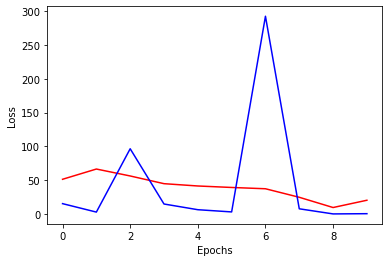

In [68]:
plt.plot(range(epochs),[loss*100 for loss in loss_train],'r')
plt.plot(range(epochs),[loss*100 for loss in loss_test],'b')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


In [77]:
print(acc_train)

[tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35100), tensor(35

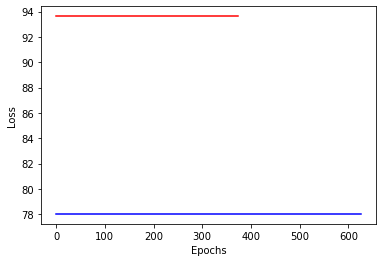

In [81]:
plt.plot(range(len(acc_train)),[acc*100/37486 for acc in acc_train ],'r')
plt.plot(range(len(acc_test)),[acc*100/6251 for acc in acc_test],'b')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()